In [468]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
custom_map = [
    "FFFFF",
    "FFFFH",
    "FFHFF",
    "FFFFG"
]
env = gym.make("FrozenLake-v1", desc=custom_map ,is_slippery=False, map_name="4x5", render_mode="human")  # Use render_mode="ansi" or "rgb_array" if not visualizing directly
for row in custom_map:
    print(" ".join(row))
    

p=[0.8,0.1,0.1] # probabilities to get to the place wanted (0.8), slippering to the right (0.1) or the left(0.1). 
gamma=0.95

F F F F F
F F F F H
F F H F F
F F F F G


# function I will use
Here i will define some function that I will use later

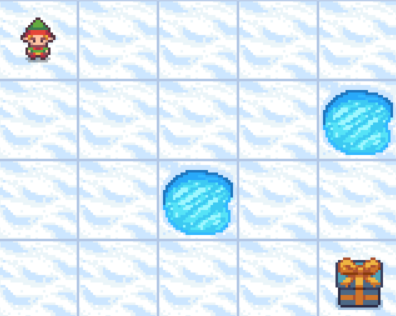

In [469]:

# I didn't use this function, but it can be used to check the answers
def move(env,action,probability=p):
    #Here I mapp the action with W,S,E,N to the corresponding digit
    if type(action)==str:
        direction_map = {"W": 0,"S": 1,"E": 2,"N": 3}
        action=direction_map[action]
    #Here I create the slipperiness effect
    slippery_coefficient=np.random.choice([0, -1, 1], p=probability)
    action=(action+slippery_coefficient)%4

    state, reward, terminated, truncated, _ = env.step(action)
    if terminated:
        if reward==0:
            # print("Game Over- fell into a hole")
            return state,-1,True # returns the state, reward and if the game ended
        else:
            # print("Game Over- reached goal")
            return state,1,True # returns the state, reward and if the game ended
    if truncated:
        # print("run out of time")
        return state,-1,True # returns the state, reward and if the game ended
    # if the game didn't end, we are on an icy point, so the reward is -0.08
    return state, -0.08, False
    
        

In [470]:
def print_array_as_map(env,array):
    desc = env.unwrapped.desc.astype(str)
    rows,cols=desc.shape
    print(np.reshape(array,(rows,cols)))
def return_policy_from_numbers_to_directions(policy):
    list_map=["W","S","E","N"]
    mapped_policy=[]
    for i in range(policy.shape[0]):
        mapped_policy.append(list_map[int(policy[i])])
    return np.array(mapped_policy)


FrozenLake gives reward if 1 of we win, and 0 for anything else. \
I will want to adjust that to the requested in the assignment.

In [471]:
def return_reward_data(is_game_over,current_reward):
    if current_reward==1:
        return 1
    if is_game_over==False:
        return -0.08
    return-1
    

def find_s_tilde_and_reward(P,s,direction):
    # P[state][action][empty brackets][_,newstate,reward,gameover]
    s_tilde=P[s][direction][0][1]
    is_game_over=P[s][direction][0][3]
    reward=P[s][direction][0][2] # our reward function is different, so we will change it
    return s_tilde,return_reward_data(is_game_over,reward)

def get_best_value_and_action(P,values,gamma,probability,s):
    sum_calculation_lst=[]
    lst=[]
    for i in range(4):
        s_tilde,reward=find_s_tilde_and_reward(P,s,i)
        sum_calculation_lst.append(reward+gamma*values[s_tilde]) #(r+gammaV)
    for i in range(4):
        lst.append(probability[0]*sum_calculation_lst[i]+probability[1]*sum_calculation_lst[(i+1)%4]+probability[2]*sum_calculation_lst[(i-1)%4])
    return max(lst),np.argmax(lst)

# Visualize 
(will be used later)

In [472]:
def draw_policy(env, state_values, policy): # this code is very similar to the code in the moodle, with small adjacments
    desc = env.unwrapped.desc.astype(str)
    h, w = desc.shape
    plt.figure(figsize=(h, w))  
    V = np.array(state_values).reshape(h, w)
    Pi = np.array(policy).reshape(h, w)

    plt.imshow(V, cmap='gray', interpolation='none')
    ax = plt.gca()
    ax.set_xticks(np.arange(w) - 0.5)
    ax.set_yticks(np.arange(h) - 0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.grid(color='blue', lw=2)
    a2uv = {0: (-1, 0),1: (0, 1),2: (1, 0),3: (0, -1)}

    for y in range(h):
        for x in range(w):
            plt.text(x, y, desc[y, x], color='g', ha='center', va='center', fontweight='bold')
            a = Pi[y, x]
            if a not in a2uv:
                continue
            if desc[y, x] in ['H', 'G']:
                continue
            dx, dy = a2uv[a]
            plt.arrow(x, y, dx * 0.3, dy * 0.3, color='m', head_width=0.1, head_length=0.1)

    plt.show()


# Policy Iteration

The algorithm is made from 2 parts.
1) We start with a random policy and with initialized values $ V_0, \pi_0$ (could be all zeros or the reward of each state).\
Then repeat until convergence those 2 parts:<br>
2) policy evaluation- we update the values using the policy and values we calculated in the previous iteration  
 $$V_{(i+1)}(s) = \sum_{s',r} p(s',r|s,\pi_i(s))[ r + \gamma V_i(s')]$$
3) policy emprovment- using the values we caculated we update the policy.
 $$\pi_{(i+1)}(s) = \argmax_a \sum_{s',r} p(s',r| s,a) [ r + \gamma V_i(s')]$$
Where $r$ is the reward going from the state $s$ to the state $\tilde s$ using the action a.

In [473]:
def initialize_values(env):
    values=np.copy(env.unwrapped.desc.astype(str)) #setting initial values to be -1 on hole, -0.08 on ice and 1 on goal, like the reward function
    state_meaning_to_value = {'H': -1.0,'F': -0.08,'G': 1.0,'S': -0.08}
    h, w = values.shape
    copy_array=np.zeros(values.shape)
    for i in range(h):
        for j in range(w):
            copy_array[i, j] = state_meaning_to_value[values[i][j]]
    return copy_array.flatten()

In [474]:
def policy_evaluation(P,desc,policy,value_previous,probability,epsilon,gamma):
    value_current=np.copy(value_previous)
    for i in range(10000):
        for s in range(len(desc)):
            if desc[s]=="F" or desc[s]=="S": # else the game is ended, so we can't get from the curret state to anywhere else.
                value_current[s]=0 #we want to sum now again, so we will set the value to 0, and in the next for loop, we will count.
                for direction,action_probability in [(policy[s],probability[0]),((policy[s]+1)%4,probability[1]),((policy[s]-1)%4,probability[2])]: 
                    direction=int(direction)
                    # we can go to the policy's direction or to the 2 adjecent ones.
                    s_tilde,reward=find_s_tilde_and_reward(P,s,direction)
                    value_current[s]+=action_probability*(reward+gamma*value_previous[s_tilde])
        if np.max(np.abs(value_previous-value_current))<=epsilon:
            break

        value_previous=np.copy(value_current)
    return value_current

In [475]:
def policy_emprovment(P,desc,values,p,gamma):
    policy=np.zeros(values.shape)
    for s in range(len(desc)):
            if desc[s]=="F" or desc[s]=="S": # else the game is ended, so we can't get from the curret state to anywhere else.
                _,policy[s]=get_best_value_and_action(P,values,gamma,p,s)
    return policy

In [476]:
def policy_iteration(env,p,gamma,epsilon1,epsilon2):
    P=env.unwrapped.P
    desc = env.unwrapped.desc.astype(str).flatten()
    policy = np.random.choice([0, 1, 2, 3], size=(env.observation_space.n)) # in holes and the goles the policy is meaningless    
    previous_values=initialize_values(env)
    for i in range(10000):
        print(f'policy: iteration number {i+1}')
        # draw_policy(env, values, policy)
        values=policy_evaluation(P,desc,policy,previous_values,p,epsilon1,gamma)
        policy=policy_emprovment(P,desc,values,p,gamma)
        if np.max(np.abs(values-previous_values))<=epsilon2:
            break
        previous_values=np.copy(values)
    values=np.round(values,2)
    return values,policy
value_policy_iteration,policy_policy_iteration=policy_iteration(env,p,gamma,0.01,0.01)
# it took 8 iteration to converge
print_array_as_map(env,return_policy_from_numbers_to_directions(policy_policy_iteration))
print_array_as_map(env,np.round(value_policy_iteration,3))

policy: iteration number 1
policy: iteration number 2
policy: iteration number 3
policy: iteration number 4
policy: iteration number 5
[['S' 'E' 'E' 'S' 'W']
 ['S' 'S' 'E' 'S' 'W']
 ['S' 'W' 'W' 'E' 'S']
 ['E' 'E' 'E' 'E' 'W']]
[[ 0.43  0.49  0.63  0.79  0.37]
 [ 0.55  0.48  0.57  1.02 -1.  ]
 [ 0.7   0.6  -1.    1.62  1.88]
 [ 0.87  1.05  1.28  1.88  1.  ]]


## In conclusion, in the policy iteration, I got that
### The Policy: 


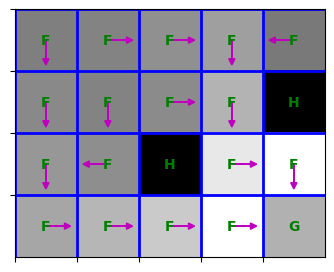

In [477]:
draw_policy(env,value_policy_iteration,policy_policy_iteration)



### The Values:
$$
\begin{bmatrix}
0.43 &0.49 &0.63 &0.79 &0.37\\
0.55 &0.48 &0.57 &1.02 & -1.00 \\
0.70 & 0.6 &-1.00 &1.62 &1.88\\
0.87 &1.05 &1.28 &1.88 &1.00  \\
\end{bmatrix}
$$


### The Time:
8 iterations in 0.0 seconds. (meaning less then 0.1 seconds)\
<br>
I stopped the calculation when i got in the values a converges of 0.01.


# Value Iteration

The algorithm is
1) We start with some initial values (could be all zeros, or the reward of the state)
2) Repeating until convergence the formula:
$$V_{(i+1)}(s) = \max_a \sum_{s',r} P(s',r | s,a) [ r + \gamma V_{i}(s')]$$

Where $r$ is the reward going from the state $s$ to the state $\tilde s$ using the action a.

In [478]:
def value_iteration(env,p,gamma,epsilon):
    P=env.unwrapped.P
    values_previous=initialize_values(env)
    values_current=np.copy(values_previous)
    current_policy=np.zeros(values_previous.shape)
    desc = env.unwrapped.desc.astype(str).flatten()
    for i in range(10000):
        print(f"this is epoch number {i}")
        # draw_policy(env,values_current,current_policy)
        for s in range(env.observation_space.n):
                if desc[s]=="F" or desc[s]=="S": # else the game is ended, so we can't get from the curret state to anywhere else.
                    values_current[s],current_policy[s]=get_best_value_and_action(P,values_previous,gamma,p,s)
        if np.max(np.abs(values_current-values_previous))<=epsilon:
            print("values reached convergence")
            break
        values_previous=np.copy(values_current)
    # because when we reach a hole or the gole the game ends, the value on those places never changes, 
    # so I will need manually to fix the values.
    values_current=np.round(values_current,2)
    return values_current,current_policy

values_value_iteration,policy_value_iteration=value_iteration(env,p,gamma,0.1)
# it took 9 iteration to converge
print_array_as_map(env,return_policy_from_numbers_to_directions(policy_value_iteration))
print_array_as_map(env,np.round(values_value_iteration,3))

this is epoch number 0
this is epoch number 1
this is epoch number 2
this is epoch number 3
this is epoch number 4
this is epoch number 5
this is epoch number 6
this is epoch number 7
this is epoch number 8
this is epoch number 9
values reached convergence
[['S' 'E' 'E' 'S' 'W']
 ['S' 'S' 'E' 'S' 'W']
 ['S' 'S' 'W' 'E' 'S']
 ['E' 'E' 'E' 'E' 'W']]
[[ 0.32  0.44  0.6   0.77  0.34]
 [ 0.5   0.45  0.56  1.01 -1.  ]
 [ 0.68  0.59 -1.    1.62  1.88]
 [ 0.85  1.05  1.28  1.88  1.  ]]


## In conclusion, in the value iteration, I got that
### The Policy: 

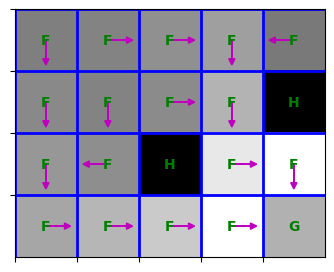

In [479]:
draw_policy(env,value_policy_iteration,policy_policy_iteration)



I will add that the policy in the holes and goal are meaningless, because if we reach them, the game is over.\
The values are random from the initializing of the policy.

### The Values:
$$
\begin{bmatrix}
0.32 &0.44 &0.60 &0.77 &0.34\\
0.50 &0.45 &0.56 &1.01 &-1.00 \\
0.68 &0.59 &-1.00 &1.62 &1.88\\
0.85 &1.05 &1.28 &1.88 &1.00  \\
\end{bmatrix}
$$



### The Time:
9 iterations in 0.0 seconds. (meaning less then 0.1 seconds)\
<br>
I stopped the calculation when i got in the values a converges of 0.01.

### We got the same policy!


# Let's look what will happen if we use a larger board

In [480]:
custom_map = [
    "FFFFHFFFFF",
    "FHFFHFFFFH",
    "FFFHFHFFFF",
    "FHHFFFFHFF",
    "FFFFHFFFFF",
    "FHFHFHFFHF",
    "FFFHFHFHHF",
    "FFFFFFFFFG"
]

env_large = gym.make("FrozenLake-v1", desc=custom_map ,is_slippery=False, map_name="8x10", render_mode="human")  # Use render_mode="ansi" or "rgb_array" if not visualizing directly
for row in custom_map:
    print(" ".join(row))

F F F F H F F F F F
F H F F H F F F F H
F F F H F H F F F F
F H H F F F F H F F
F F F F H F F F F F
F H F H F H F F H F
F F F H F H F H H F
F F F F F F F F F G


c:\Users\hugo fis\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\toy_text\frozen_lake.py:242: RuntimeWarning: invalid value encountered in divide
  self.initial_state_distrib /= self.initial_state_distrib.sum()


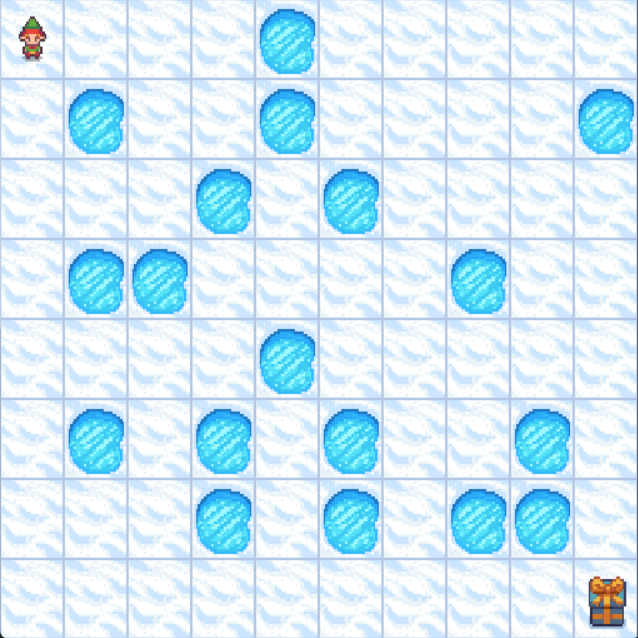

# Policy Iteration Large Board

In [481]:
values_policy_iteration_large_board,policy_policy_iteration_large_board=policy_iteration(env_large,p,gamma,0.1,0.01)
# it took 15 iteration to converge

policy: iteration number 1
policy: iteration number 2
policy: iteration number 3
policy: iteration number 4
policy: iteration number 5
policy: iteration number 6
policy: iteration number 7
policy: iteration number 8
policy: iteration number 9
policy: iteration number 10
policy: iteration number 11


In [482]:
print_array_as_map(env_large,return_policy_from_numbers_to_directions(policy_policy_iteration_large_board))
print_array_as_map(env_large,np.round(values_policy_iteration_large_board,3))

[['S' 'W' 'W' 'W' 'W' 'E' 'E' 'S' 'S' 'W']
 ['S' 'W' 'N' 'N' 'W' 'E' 'E' 'S' 'S' 'W']
 ['S' 'W' 'W' 'W' 'S' 'W' 'E' 'E' 'E' 'S']
 ['S' 'W' 'W' 'E' 'E' 'S' 'S' 'W' 'E' 'S']
 ['S' 'W' 'S' 'W' 'W' 'E' 'E' 'E' 'E' 'S']
 ['S' 'W' 'S' 'W' 'S' 'W' 'S' 'N' 'W' 'S']
 ['S' 'S' 'S' 'W' 'S' 'W' 'S' 'W' 'W' 'S']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'W']]
[[-1.21 -1.31 -1.34 -1.37 -1.   -0.41 -0.32 -0.25 -0.19 -0.46]
 [-1.17 -1.   -1.43 -1.45 -1.   -0.49 -0.25 -0.16 -0.06 -1.  ]
 [-1.05 -1.25 -1.35 -1.   -1.04 -1.   -0.19 -0.06  0.29  0.44]
 [-0.99 -1.   -1.   -0.95 -0.77 -0.53 -0.44 -1.    0.43  0.59]
 [-0.82 -1.08 -0.94 -1.07 -1.   -0.44 -0.17 -0.03  0.35  0.76]
 [-0.74 -1.   -0.86 -1.   -0.72 -1.   -0.22 -0.31 -1.    0.96]
 [-0.53 -0.47 -0.53 -1.   -0.34 -1.    0.1  -1.   -1.    1.5 ]
 [-0.46 -0.38 -0.29 -0.17  0.14  0.32  0.73  0.96  1.5   1.  ]]


# Value Iteration Large Board

In [483]:
values_value_iteration_large_board,policy_value_iteration_large_board=value_iteration(env_large,p,gamma,0.0001)
# it took 43 iteration to converge

this is epoch number 0
this is epoch number 1
this is epoch number 2
this is epoch number 3
this is epoch number 4
this is epoch number 5
this is epoch number 6
this is epoch number 7
this is epoch number 8
this is epoch number 9
this is epoch number 10
this is epoch number 11
this is epoch number 12
this is epoch number 13
this is epoch number 14
this is epoch number 15
this is epoch number 16
this is epoch number 17
this is epoch number 18
this is epoch number 19
this is epoch number 20
this is epoch number 21
this is epoch number 22
this is epoch number 23
this is epoch number 24
this is epoch number 25
this is epoch number 26
this is epoch number 27
this is epoch number 28
this is epoch number 29
this is epoch number 30
this is epoch number 31
this is epoch number 32
this is epoch number 33
this is epoch number 34
this is epoch number 35
this is epoch number 36
this is epoch number 37
this is epoch number 38
this is epoch number 39
this is epoch number 40
this is epoch number 41
th

In [484]:
print_array_as_map(env_large,return_policy_from_numbers_to_directions(policy_value_iteration_large_board))
print_array_as_map(env_large,np.round(values_value_iteration_large_board,3))

[['S' 'W' 'W' 'W' 'W' 'E' 'E' 'S' 'S' 'W']
 ['S' 'W' 'N' 'N' 'W' 'E' 'E' 'S' 'S' 'W']
 ['S' 'W' 'W' 'W' 'S' 'W' 'E' 'E' 'E' 'S']
 ['S' 'W' 'W' 'E' 'E' 'S' 'S' 'W' 'E' 'S']
 ['S' 'W' 'S' 'W' 'W' 'E' 'E' 'E' 'E' 'S']
 ['S' 'W' 'S' 'W' 'S' 'W' 'S' 'N' 'W' 'S']
 ['S' 'S' 'S' 'W' 'S' 'W' 'S' 'W' 'W' 'S']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'W']]
[[-1.21 -1.31 -1.34 -1.37 -1.   -0.41 -0.32 -0.25 -0.19 -0.46]
 [-1.17 -1.   -1.42 -1.44 -1.   -0.49 -0.25 -0.16 -0.06 -1.  ]
 [-1.05 -1.25 -1.35 -1.   -1.04 -1.   -0.19 -0.06  0.29  0.44]
 [-0.99 -1.   -1.   -0.95 -0.77 -0.53 -0.44 -1.    0.43  0.59]
 [-0.82 -1.08 -0.94 -1.07 -1.   -0.44 -0.17 -0.03  0.35  0.76]
 [-0.74 -1.   -0.86 -1.   -0.72 -1.   -0.22 -0.31 -1.    0.96]
 [-0.53 -0.47 -0.53 -1.   -0.34 -1.    0.1  -1.   -1.    1.5 ]
 [-0.46 -0.38 -0.29 -0.17  0.14  0.32  0.73  0.96  1.5   1.  ]]


# Final Results


# Policy Iteration

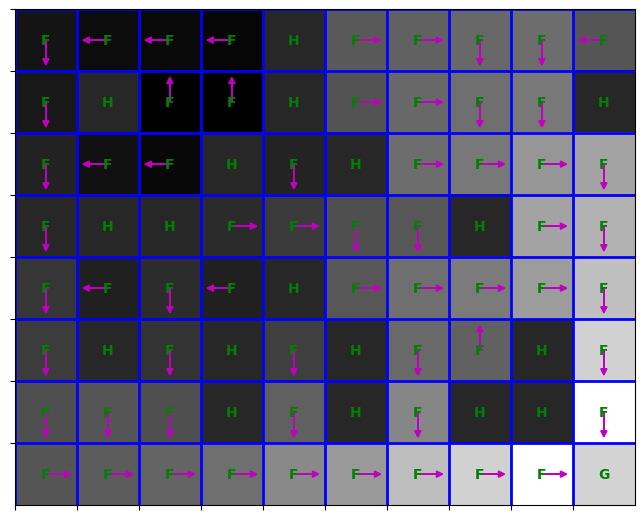

In [485]:
draw_policy(env_large,value_policy_iteration_large_board,policy_policy_iteration_large_board)

# Value Iteration


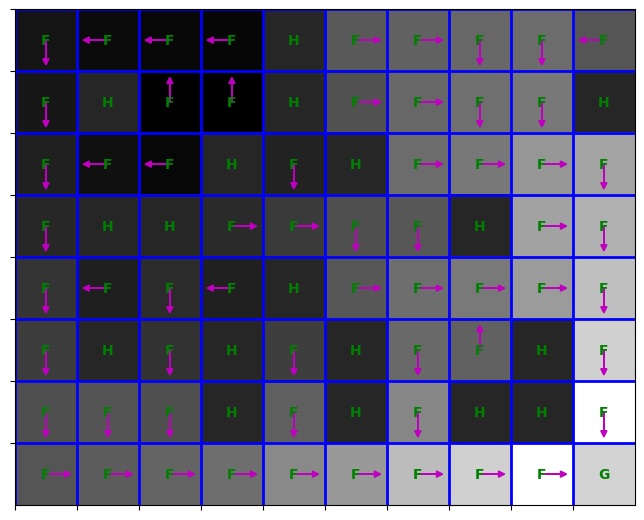

In [486]:
draw_policy(env_large,values_value_iteration_large_board,policy_value_iteration_large_board)

Both took less then 0.1s. \
The value iteration took 43 iterations while the policy iteration took inly 15\
### We got the same policy!

# Conclusions
1) Both ways gave us good results in very short time.
2) As we have seen, the policy iteration has a more complicated algorithm than the value iteration.
3) The policy iteration is harder to compute in comparison to the value iteration, the algorithm is made out of 2 parts, the second part of the policy iteration is almost the same as the value iteration algorithm ( the only change is taking argmax in the policy iteration and max in the value iteration), and the first part is an entire part where we try to find convergence, therefore it's expensiver to computer.
4) Both ways are guaranteed to converge.
5) In theory, the policy iteration though more expensive to compute, should converge faster (in the aspect of time) than the value iteration. (We got that they both did the same in the time aspect less than 0.1 seconds)
6) The policy iteration takes less time to converge, it make sense because each iteration is expensiver the an iteration in the value iteration.\
8 iterations against 9 iterations in the small board and 15 iterations against 43 iterations in the large board